## UNET Model for the CAMUS dataset using the MONAI platform

### Purpose

This notebook will explore the models that will do a segmentation of the left ventricle. Here I will use the CAMUS dataset with the ES and ED phases with their corresponding ground truth masks as my input and output for the model. 

In [264]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision,tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import cv2" || pip install opencv-python

In [265]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


Import all the necessary packages.

In [266]:
import monai
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import medpy
import PIL
import os
import shutil
import tempfile
from pathlib import Path
import pprint
import cv2

In [267]:
from monai.config import print_config
print_config()

MONAI version: 0.6.0
Numpy version: 1.24.1
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Set the base directory where the data resides. 
If using Google Drive set here

In [268]:
%env DATA_DIRECTORY = /content/drive/MyDrive/LVEF

env: DATA_DIRECTORY=/content/drive/MyDrive/LVEF


If using a local drive, set directory below

In [269]:

%env DATA_DIRECTORY =  C:\Workspace\Practice\Python\PyTorch

env: DATA_DIRECTORY=C:\Workspace\Practice\Python\PyTorch


In [270]:
## if environment variable is not set , get a temp directory. 
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

C:\Workspace\Practice\Python\PyTorch


In [271]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

Download and extract the CAMUS dataset. This step is not needed if the data was downloaded and unzipped.

In [272]:
pp = pprint.PrettyPrinter()
from monai.utils import set_determinism
set_determinism(seed=0)
from monai.apps import download_and_extract, extractall

In [273]:
CAMUS_ORIGINAL_DATA_DIR = 'CAMUS/original_data/data'
CAMUS_DATA_DIR = 'New_CAMUS_png/CAMUS'

In [274]:
# May not work on WIndows
#resource = "https://scholar.cu.edu.eg/Dataset_BUSI.zip"
compressed_file = ROOT_DIR.joinpath("CAMUS.zip")
DATA_DIR = ROOT_DIR.joinpath(CAMUS_DATA_DIR)
if not os.path.exists(DATA_DIR):
    extractall(compressed_file, ROOT_DIR)
checkPathExists(DATA_DIR)

Path C:\Workspace\Practice\Python\PyTorch\New_CAMUS_png\CAMUS accessible


Organize the file names used for training and testing into Python lists for easy access when needed.

In [275]:
TRAINING_DATA_DIR = DATA_DIR.joinpath('Training')
TESTING_DATA_DIR = DATA_DIR.joinpath('Testing')
TWO_CHANNEL = '2CH'
FOUR_CHANNEL = '4CH'
PHASE_NAMES = ['ED', 'ES']

In [276]:
### Set the file list as
#[ 
#   ED [(input_file, mask_file), (input_file, mask_file), ....]
#   ES [(input_file, mask_file), (input_file, mask_file), ....]
#]
def data_directories(data_path, class_names, chamber_view):
    num_phases = len(class_names)
    patient_list = [x for x in data_path.iterdir() if x.is_dir()]

    image_files_list = [
        [
            (p, Path(str(p).replace(f"{class_names[i]}", f"{class_names[i]}_mask")))
            for x in patient_list
            for j, p in enumerate(x.glob(f"**/{chamber_view}*{class_names[i]}.png"))
        ]
        for i in range(num_phases)
    ]
    return image_files_list

In [277]:
training_2chamber_image_files = data_directories(TRAINING_DATA_DIR, PHASE_NAMES, TWO_CHANNEL)
training_4chamber_image_files = data_directories(TRAINING_DATA_DIR, PHASE_NAMES, FOUR_CHANNEL)
testing_2chamber_image_files = data_directories(TESTING_DATA_DIR, PHASE_NAMES, TWO_CHANNEL)
testing_4chamber_image_files = data_directories(TESTING_DATA_DIR, PHASE_NAMES, FOUR_CHANNEL)
#pp.pprint(training_2chamber_image_files[1])

In [278]:
# num_total = len(testing_2chamber_image_files[0])
# for i in range(num_total):
#     for x in range(2):
#         image = cv2.imread(str(testing_2chamber_image_files[x][i][1]))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image[image == 85] = 0
#         image[image == 255] = 0
#         image[image == 170] = 255
#         mask_file = str(testing_2chamber_image_files[x][i][1]).replace("gt", "mask")
#         cv2.imwrite(mask_file, image)

In [279]:
def data_description(image_files_list):
    num_total = len(image_files_list[0])
    image_width, image_height = PIL.Image.open(image_files_list[0][0][0]).size
    print(f"Total Image Count: {num_total}")
    print(f"Image Dimensions: {image_width} x {image_height}")

In [280]:
print(f"Two Chamber Training Data Count")
data_description(training_2chamber_image_files)
print("-------------")
print(f"Four Chamber Training Data Count")
data_description(training_4chamber_image_files)
print("-------------")
print(f"Two Chamber Testing Data Count")
data_description(testing_2chamber_image_files)
print("-------------")
print(f"Four Chamber Testing Data Count")
data_description(testing_4chamber_image_files)
print("-------------")

Two Chamber Training Data Count
Total Image Count: 400
Image Dimensions: 256 x 256
-------------
Four Chamber Training Data Count
Total Image Count: 400
Image Dimensions: 256 x 256
-------------
Two Chamber Testing Data Count
Total Image Count: 50
Image Dimensions: 256 x 256
-------------
Four Chamber Testing Data Count
Total Image Count: 50
Image Dimensions: 256 x 256
-------------


Lets load the information file as a pandas dataframe

In [281]:
TRAINING_2CH_INFO_DIR = TRAINING_DATA_DIR.joinpath('training_2ch_info')
TRAINING_4CH_INFO_DIR = TRAINING_DATA_DIR.joinpath('training_4ch_info')
TESTING_2CH_INFO_DIR = TESTING_DATA_DIR.joinpath('testing_2ch_info')
TESTING_4CH_INFO_DIR = TESTING_DATA_DIR.joinpath('testing_4ch_info')
checkPathExists(TRAINING_2CH_INFO_DIR)
checkPathExists(TRAINING_4CH_INFO_DIR)
checkPathExists(TESTING_2CH_INFO_DIR)
checkPathExists(TESTING_4CH_INFO_DIR)

Path C:\Workspace\Practice\Python\PyTorch\New_CAMUS_png\CAMUS\Training\training_2ch_info accessible
Path C:\Workspace\Practice\Python\PyTorch\New_CAMUS_png\CAMUS\Training\training_4ch_info accessible
Path C:\Workspace\Practice\Python\PyTorch\New_CAMUS_png\CAMUS\Testing\testing_2ch_info accessible
Path C:\Workspace\Practice\Python\PyTorch\New_CAMUS_png\CAMUS\Testing\testing_4ch_info accessible


In [282]:
def data_info_file(info_dir, chamber_view):
    info_df = pd.DataFrame()
    for file in info_dir.glob(f"**/*.cfg"):
        with open(file) as f: 
            data = f.readlines() 
            data = [x.rstrip('\n') for x in data]
            data = { f"{x.split(': ')[0]}_{chamber_view}": x.split(': ')[1] for x in data}
            data['id'] = str(file.name).split('_')[0]
            info_df = pd.concat([info_df, pd.DataFrame([data])])
    info_df = info_df.reset_index(drop=True)
    info_df = info_df.set_index('id')
    return info_df

In [283]:
training_2chamber_info_df = data_info_file(TRAINING_2CH_INFO_DIR, TWO_CHANNEL)
training_4chamber_info_df = data_info_file(TRAINING_4CH_INFO_DIR, FOUR_CHANNEL)
testing_2chamber_info_df = data_info_file(TESTING_2CH_INFO_DIR, TWO_CHANNEL)
testing_4chamber_info_df = data_info_file(TESTING_4CH_INFO_DIR, FOUR_CHANNEL)

In [284]:
training_2chamber_info_df.LVedv_2CH = training_2chamber_info_df.LVedv_2CH.astype('float32')
training_2chamber_info_df.LVesv_2CH = training_2chamber_info_df.LVedv_2CH.astype('float32')
training_2chamber_info_df.LVef_2CH = training_2chamber_info_df.LVef_2CH.astype('float32')

training_4chamber_info_df.LVedv_4CH = training_4chamber_info_df.LVedv_4CH.astype('float32')
training_4chamber_info_df.LVesv_4CH = training_4chamber_info_df.LVedv_4CH.astype('float32')
training_4chamber_info_df.LVef_4CH = training_4chamber_info_df.LVef_4CH.astype('float32')

testing_2chamber_info_df.LVedv_2CH = testing_2chamber_info_df.LVedv_2CH.astype('float32')
testing_2chamber_info_df.LVesv_2CH = testing_2chamber_info_df.LVedv_2CH.astype('float32')
testing_2chamber_info_df.LVef_2CH = testing_2chamber_info_df.LVef_2CH.astype('float32')

testing_4chamber_info_df.LVedv_4CH = testing_4chamber_info_df.LVedv_4CH.astype('float32')
testing_4chamber_info_df.LVesv_4CH = testing_4chamber_info_df.LVedv_4CH.astype('float32')
testing_4chamber_info_df.LVef_4CH = testing_4chamber_info_df.LVef_4CH.astype('float32')

In [285]:
## Save the files here for easy access later

### EDA for CAMUS dataset

Lets look at the characteristics of the CAMUS data

According to the American Heart Association:

    A left ventricle (LV) ejection fraction of about 50% to 70% is categorized as normal.
    A mildly reduced LV ejection fraction is usually between 41% and 49%.
    A reduced LV ejection fraction is usually 40% or less.

1. Distribute the Training data into normal, mild, and abnormal

In [286]:
def data_hfclass(df):
    lvef_class = []
    for i in df:
        if i >= 50:
            lvef_class.append('Normal')
        elif i > 40:
            lvef_class.append('Mild')
        else:
            lvef_class.append('Abnormal')
    lv_class = pd.Series(lvef_class, name='HFClass')
    lv_class = lv_class.astype('category')
    lv_class = lv_class.cat.set_categories(["Normal", "Mild", "Abnormal"], ordered=True)
    lv_class.index = df.index
    return lv_class

In [287]:
training_2chamber_info_df = pd.concat([training_2chamber_info_df, data_hfclass(training_2chamber_info_df.LVef_2CH)], axis=1)
training_4chamber_info_df = pd.concat([training_4chamber_info_df, data_hfclass(training_4chamber_info_df.LVef_4CH)], axis=1)
testing_2chamber_info_df = pd.concat([testing_2chamber_info_df, data_hfclass(testing_2chamber_info_df.LVef_2CH)], axis=1)
testing_4chamber_info_df = pd.concat([testing_4chamber_info_df, data_hfclass(testing_4chamber_info_df.LVef_4CH)], axis=1)

2. Visualize the training/testing data for 2 chamber and 4 chamber in terms of their Diagnostic classes

In [288]:
training_2chamber_info_df.Age_2CH = training_2chamber_info_df.Age_2CH.astype('int')
training_4chamber_info_df.Age_4CH = training_4chamber_info_df.Age_4CH.astype('int')
testing_2chamber_info_df.Age_2CH = testing_2chamber_info_df.Age_2CH.astype('int')
testing_4chamber_info_df.Age_4CH = testing_4chamber_info_df.Age_4CH.astype('int')

In [289]:
def generate_pie_plot(labels, title="Categories", ax = None):
    proportions = []
    sz = len(labels.unique())
    total = labels.value_counts().sum()
    for c in range(sz):
        prop = labels.value_counts()[c]
        print(f"Proportion of data in class {c} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=labels.sort_values().unique(), autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

Proportion of data in class 0 is 274 : 60.89 %
Proportion of data in class 1 is 103 : 22.89 %
Proportion of data in class 2 is 73 : 16.22 %
Proportion of data in class 0 is 33 : 66.00 %
Proportion of data in class 1 is 10 : 20.00 %
Proportion of data in class 2 is 7 : 14.00 %
Proportion of data in class 0 is 274 : 60.89 %
Proportion of data in class 1 is 103 : 22.89 %
Proportion of data in class 2 is 73 : 16.22 %
Proportion of data in class 0 is 33 : 66.00 %
Proportion of data in class 1 is 10 : 20.00 %
Proportion of data in class 2 is 7 : 14.00 %


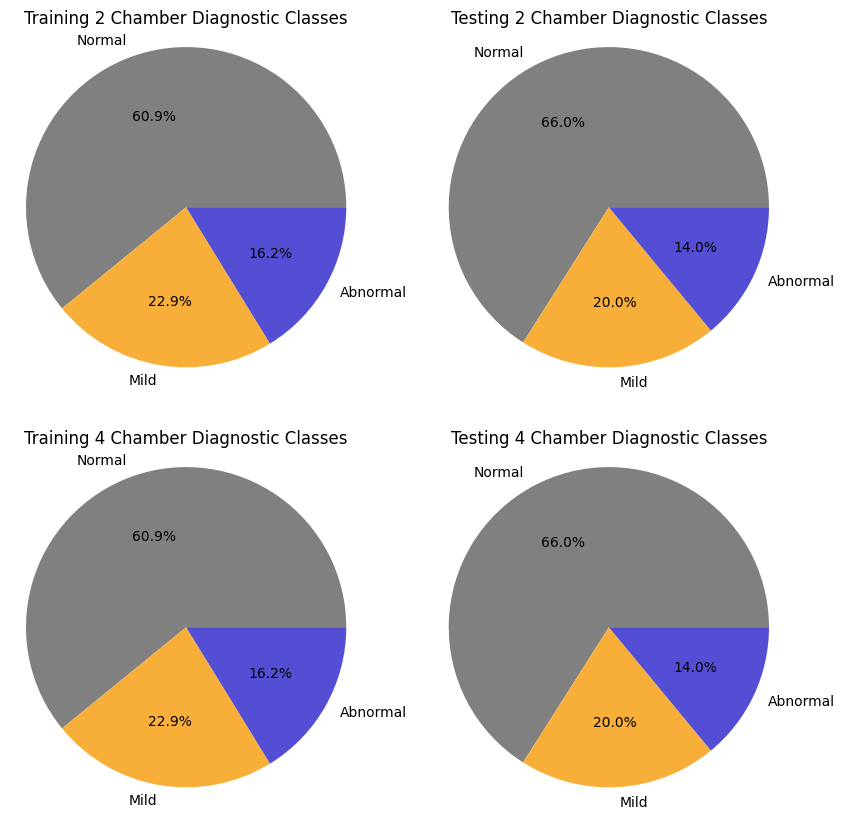

In [290]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
generate_pie_plot(training_2chamber_info_df.HFClass, 'Training 2 Chamber Diagnostic Classes', ax[0][0])
generate_pie_plot(testing_2chamber_info_df.HFClass, 'Testing 2 Chamber Diagnostic Classes', ax[0][1])
generate_pie_plot(training_4chamber_info_df.HFClass, 'Training 4 Chamber Diagnostic Classes', ax[1][0])
generate_pie_plot(testing_4chamber_info_df.HFClass, 'Testing 4 Chamber Diagnostic Classes', ax[1][1])

The training and testing data is similarly distributed based on its diagnostic class

3. Lets visualize the distribution of the diagnostic classes in terms of the age groups

In [291]:
def generate_hfclass_age_plot(df, column_name, title='Distribution on Age'):
    lessthan50_df = df[df[column_name]<50]
    bet50_60_df = df[df[column_name].between(50, 60, inclusive="left")]
    bet60_70_df = df[df[column_name].between(60, 70, inclusive="left")]
    bet70_80_df = df[df[column_name].between(70, 80, inclusive="left")]
    gtthan80_df = df[df[column_name]>=80]

    hfclass_age_df = pd.concat([
                                pd.DataFrame(lessthan50_df.HFClass.value_counts()),
                                pd.DataFrame(bet50_60_df.HFClass.value_counts()), 
                                pd.DataFrame(bet60_70_df.HFClass.value_counts()),
                                pd.DataFrame(bet70_80_df.HFClass.value_counts()),
                                pd.DataFrame(gtthan80_df.HFClass.value_counts())], axis=1)
    hfclass_age_df.columns = ['Less_than_50', 'Btwn_50_60', 'Btwn_60_70', 'Btwn_70_80', 'Gt_than_80']
    hfclass_age_df = hfclass_age_df.T
    hfclass_age_df = hfclass_age_df[['Normal', 'Mild', 'Abnormal']]
    print(hfclass_age_df)
    hfclass_age_df.plot(kind='bar', stacked=True, title=title, color=['gray', '#f8af3a', '#544ED5'])

              Normal  Mild  Abnormal
Less_than_50      38    11         7
Btwn_50_60        63    23        15
Btwn_60_70        52    18         7
Btwn_70_80        88    31        32
Gt_than_80        33    20        12
              Normal  Mild  Abnormal
Less_than_50       4     1         4
Btwn_50_60         6     4         4
Btwn_60_70         3     0         0
Btwn_70_80        17     1         1
Gt_than_80         3     1         1


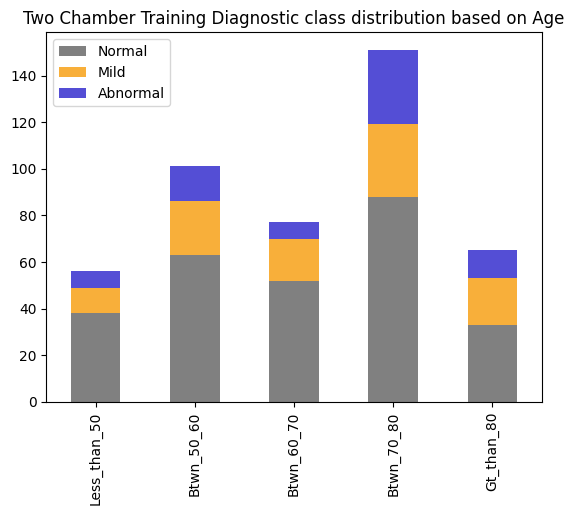

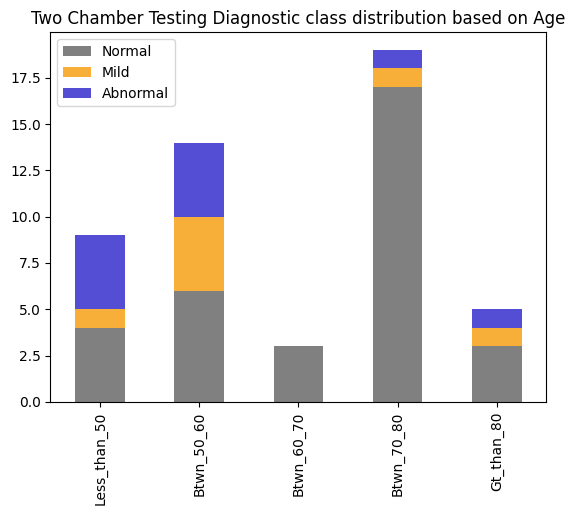

In [292]:
generate_hfclass_age_plot(training_2chamber_info_df, "Age_2CH", title="Two Chamber Training Diagnostic class distribution based on Age")
generate_hfclass_age_plot(testing_2chamber_info_df, "Age_2CH", title="Two Chamber Testing Diagnostic class distribution based on Age")

From the training data distribution based on age groups, we see that most abnormal and mild cases are in the 70 years to 80 years age group. Under 50 age group do not have many abnormal or mild cases. 

4. Lets visualize the distribution of males and females within each age group.

In [293]:
def generate_sex_age_plot(df, column_name, title='Distribution on Age'):
    lessthan50_df = df[df[column_name]<50]
    bet50_60_df = df[df[column_name].between(50, 60, inclusive="left")]
    bet60_70_df = df[df[column_name].between(60, 70, inclusive="left")]
    bet70_80_df = df[df[column_name].between(70, 80, inclusive="left")]
    gtthan80_df = df[df[column_name]>=80]

    hfclass_age_df = pd.concat([
                                pd.DataFrame(lessthan50_df.Sex_2CH.value_counts()),
                                pd.DataFrame(bet50_60_df.Sex_2CH.value_counts()), 
                                pd.DataFrame(bet60_70_df.Sex_2CH.value_counts()),
                                pd.DataFrame(bet70_80_df.Sex_2CH.value_counts()),
                                pd.DataFrame(gtthan80_df.Sex_2CH.value_counts())], axis=1)
    hfclass_age_df.columns = ['Less_than_50', 'Btwn_50_60', 'Btwn_60_70', 'Btwn_70_80', 'Gt_than_80']
    hfclass_age_df = hfclass_age_df.T
    hfclass_age_df = hfclass_age_df[['M', 'F']]
    print(hfclass_age_df)
    hfclass_age_df.plot(kind='bar', title=title, color=['#33aee7', '#fc1d75'])   #'#5c849c', '#c9ada9'

                M   F
Less_than_50   29  27
Btwn_50_60     68  33
Btwn_60_70     52  25
Btwn_70_80    105  46
Gt_than_80     38  27
                 M    F
Less_than_50   6.0  3.0
Btwn_50_60    12.0  2.0
Btwn_60_70     3.0  NaN
Btwn_70_80    15.0  4.0
Gt_than_80     2.0  3.0


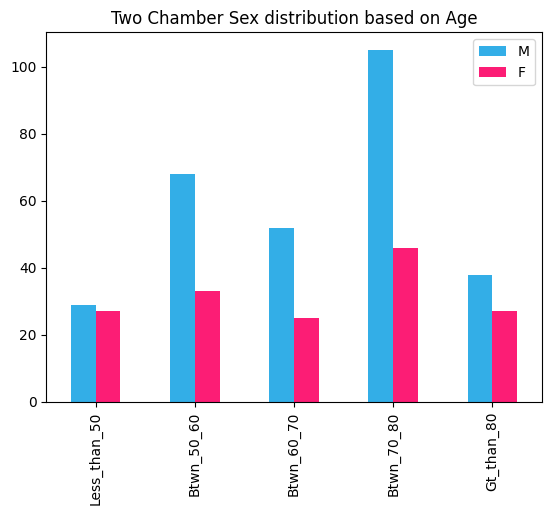

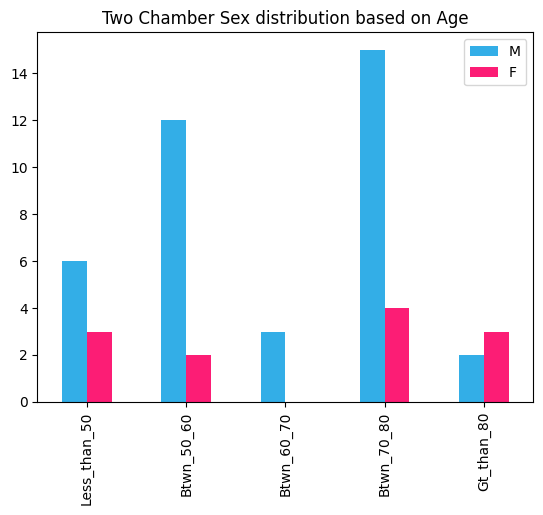

In [294]:
generate_sex_age_plot(training_2chamber_info_df, "Age_2CH", title="Two Chamber Sex distribution based on Age")
generate_sex_age_plot(testing_2chamber_info_df, "Age_2CH", title="Two Chamber Sex distribution based on Age")

### Conclusion

1. There are more abnormal cases in the training set for the 70-80 age group
2. There are more males than females in the distribution
3. The training and testing distributions are similar in terms of their diagnostic classes. 

### UNET Segmentation using MONAI

I will run the UNET from the MONAI framework without any updates to the base architecture.

I am only using the 4 chamber views for the segmentation.

In [295]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    z_min, z_max = np.abs(mask).min(), np.abs(mask).max()
    plt.imshow(mask, cmap=cmap, alpha=alpha, vmin = z_min, vmax=z_max)

In [296]:
def displaySampleImages(image_files_list, image_info_df):
    plt.subplots(4, 4, figsize=(10,10))
    num_total = len(image_files_list[0])
    for i, k in enumerate(np.random.randint(num_total, size=4)):
        for x in range(2):
            for y in range(2):
                im = PIL.Image.open(image_files_list[x][k][y])
                #print(image_info_df['ImageQuality_4CH'].loc[image_files_list[x][k][y].parent.name])
                arr = np.array(im)
                col = 2*x+y
                plt.subplot(4, 4, 4*i+col+1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                plt.xlabel(image_info_df['ImageQuality_4CH'].loc[image_files_list[x][k][y].parent.name])
                if y%2==0:
                    show_image(arr)
                else:
                    #arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
                    #arr[arr == 170] = 0
                    #print(np.unique(arr))
                    show_mask(arr1, arr, cmap='jet')
                arr1 = arr.copy()
      #plt.imshow(arr, cmap="gray", vmin=0, vmax=255)


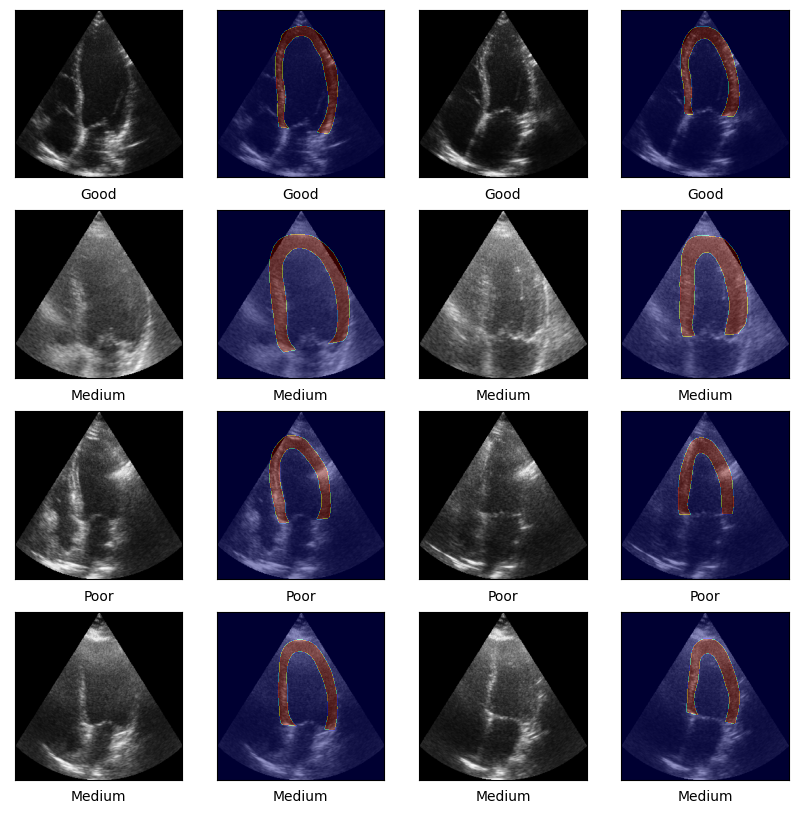

In [297]:
displaySampleImages(training_4chamber_image_files, training_4chamber_info_df)

Partition the data into training, validation and test

In [298]:
from monai.data import partition_dataset_classes, partition_dataset
image_class = ['Normal', 'Mild', 'Abnormal']
train_inds, val_inds, test_inds = partition_dataset(np.arange(len(training_4chamber_image_files[0])),
                                                    (9.0, 1, 0), 
                                                    shuffle=True)

# Training Set
train_ED = [training_4chamber_image_files[0][i] for i in train_inds]
train_ES = [training_4chamber_image_files[1][i] for i in train_inds]
train_X = train_ED + train_ES
#pp.pprint(train_X)

# Validation Set
val_ED = [training_4chamber_image_files[0][i] for i in val_inds]
val_ES = [training_4chamber_image_files[1][i] for i in val_inds]
val_X = val_ED + val_ES
#pp.pprint(val_X)

# Validation Set
test_inds = len(testing_4chamber_image_files[0])
test_ED = [testing_4chamber_image_files[0][i] for i in range(test_inds)]
test_ES = [testing_4chamber_image_files[1][i] for i in range(test_inds)]
test_X = test_ED + test_ES
#pp.pprint(test_X)

print(f"Training Count: {len(train_X)}, Validation Count: {len(val_X)}, Test Count: {len(test_X)}")

Training Count: 720, Validation Count: 80, Test Count: 100


Build a dictionary for UNET

In [299]:
train_dicts = [{"image": str(image_name), "label": str(label_name)} for image_name, label_name in train_X]
val_dicts = [{"image": str(image_name), "label": str(label_name)} for image_name, label_name in val_X]
test_dicts = [{"image": str(image_name), "label": str(label_name)} for image_name, label_name in test_X]

Build the Transforms: 
1. Resize all images to the same dimensions
2. Scale Intensity to between 0 and 1
3. Add a Channel Dimension first

In [300]:
from monai.transforms import (
    Compose,
    LoadImaged,
    Lambdad,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    EnsureTyped
)

train_transforms = Compose(
    [
    LoadImaged(keys=["image", "label"]),
#    Resized(keys=["image", "label"], spatial_size=(500,500)),
    EnsureChannelFirstd(keys=["image", "label"]),
    #Lambdad(keys=["label"], func=lambda x: x[0:1]*0.2125 + x[1:2]*0.7154 + x[2:3]*0.0721),
    ScaleIntensityd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"])
    ]
)

val_transforms = Compose(
    [
    LoadImaged(keys=["image", "label"]),
#    Resized(keys=["image", "label"], spatial_size=(500, 500)),
    EnsureChannelFirstd(keys=["image", "label"]),
    #Lambdad(keys=["label"], func=lambda x: x[0:1]*0.2125 + x[1:2]*0.7154 + x[2:3]*0.0721),
    ScaleIntensityd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"])
    ]
)

Set up the Data Loader. Use a cached dataset to have the images in the cache once loaded

In [301]:
from monai.transforms import LoadImage
loader = LoadImage(dtype=np.float32, image_only=True)
image = loader(train_dicts[0]["image"])

In [302]:
loader = LoadImaged(keys=("image", "label"), image_only=False)
data_dict = loader(train_dicts[0])

In [303]:
from monai.data import CacheDataset, DataLoader
train_ds = CacheDataset(data=train_dicts, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_dicts, transform=val_transforms, cache_rate=1.0, num_workers=10)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

test_ds = CacheDataset(data=test_dicts, transform=val_transforms, cache_rate=1.0, num_workers=10)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 342.24it/s]


Build the UNET model now

In [304]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device =torch.device("cuda:0")
model = UNet(
    dimensions = 2,
    in_channels = 4,
    out_channels = 1,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm=Norm.BATCH
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax = True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [305]:
# from monai.transforms import Lambdad  
# import numpy as np
# lambd = Lambdad(keys='image', func=lambda x: x[0:1]*0.2125 + x[1:2]*0.7154 + x[2:3]*0.0721)
# data = {'image': np.ones((3, 10, 10))}
# transformed = lambd(data)
# transformed['image'].shape

(1, 256, 256)
(0, 256, 256)
[]


TypeError: Invalid shape (0, 256, 256) for image data

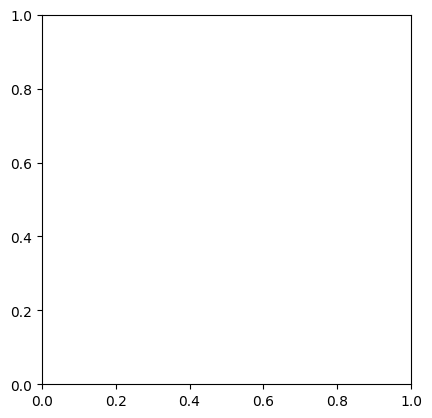

In [306]:
im = PIL.Image.open(training_4chamber_image_files[0][0][1])
loader = LoadImaged(keys='label')
image = loader(train_dicts[0])
#arr = np.array(im)
#print(image)
ed  = EnsureChannelFirstd(keys='label')
lambd = Lambdad(keys='label', func=lambda x: x[0:1]*0.2125 + x[1:2]*0.7154 + x[2:3]*0.0721)
#show_image(arr)
arr1 = ed(image)
print(arr1['label'].shape)
arr2 = lambd(arr1)
print(arr2['label'].shape)
print(np.unique(arr2['label']))
show_image(np.squeeze(arr2['label']))

Train the model

In [307]:
from monai.data.utils import decollate_batch
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 2
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_trans = Compose([Activations(sigmoid=True), AsDiscrete()])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        #print(step)
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        #print(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    ROOT_DIR, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/2


c:\Users\212364473\.virtualenvs\PyTorch-arlbtak8\lib\site-packages\monai\losses\dice.py:121: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
c:\Users\212364473\.virtualenvs\PyTorch-arlbtak8\lib\site-packages\monai\losses\dice.py:130: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/360, train_loss: 0.8855
2/360, train_loss: 0.8143
3/360, train_loss: 0.8917
4/360, train_loss: 0.7506
5/360, train_loss: 0.8447
6/360, train_loss: 0.8364
7/360, train_loss: 0.7592
8/360, train_loss: 0.6696
9/360, train_loss: 0.7939
10/360, train_loss: 0.8099
11/360, train_loss: 0.7507
12/360, train_loss: 0.6766
13/360, train_loss: 0.7120
14/360, train_loss: 0.7676
15/360, train_loss: 0.7280
16/360, train_loss: 0.7376
17/360, train_loss: 0.6307
18/360, train_loss: 0.7283
19/360, train_loss: 0.6468
20/360, train_loss: 0.7670
21/360, train_loss: 0.6385
22/360, train_loss: 0.6842
23/360, train_loss: 0.5984
24/360, train_loss: 0.6708
25/360, train_loss: 0.6582
26/360, train_loss: 0.6361
27/360, train_loss: 0.6523
28/360, train_loss: 0.6142
29/360, train_loss: 0.6359
30/360, train_loss: 0.5576
31/360, train_loss: 0.5285
32/360, train_loss: 0.6058
33/360, train_loss: 0.6101
34/360, train_loss: 0.4851
35/360, train_loss: 0.5208
36/360, train_loss: 0.5614
37/360, train_loss: 0.5315
38/360, tr

c:\Users\212364473\.virtualenvs\PyTorch-arlbtak8\lib\site-packages\monai\metrics\meandice.py:73: UserWarning: y_pred should be a binarized tensor.
  warnings.warn("y_pred should be a binarized tensor.")


saved new best metric model
current epoch: 2 current mean dice: 0.2209
best mean dice: 0.2209 at epoch: 2
train completed, best_metric: 0.2209 at epoch: 2


Loss and Dice 

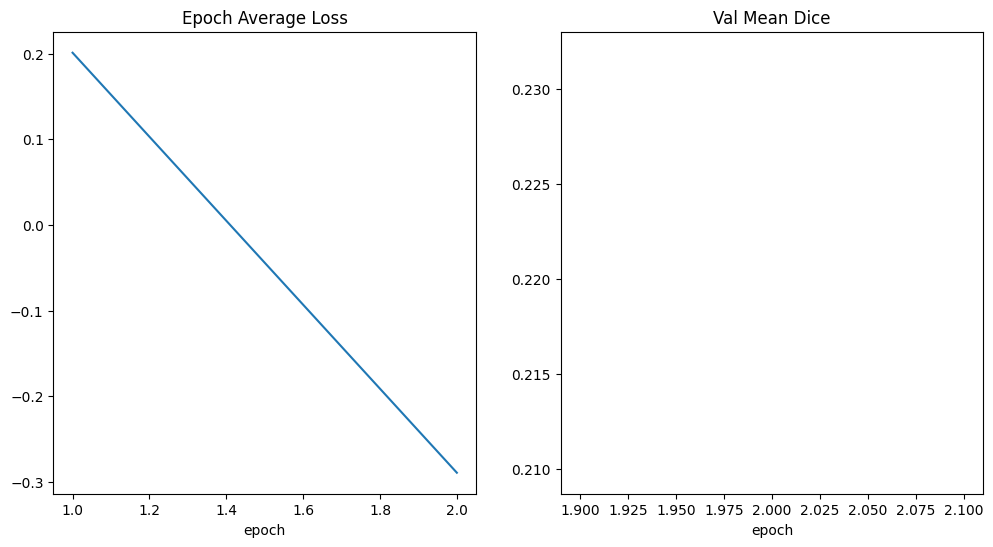

In [308]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()